Free diffusion

In [16]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit

In [17]:
# Physical parameters
T_K = 300
k_b = 1.3806452e-23
R_m = 1e-6
m_kg = 1.1e-14 
viscosity_NS_m2 = 0.001
load = 6*np.pi*viscosity_NS_m2*R_m 
tau = m_kg/load
einstein_diffusion = k_b*T_K/load
dt_s = 100*tau
print("einstein_diffusion coefficient",einstein_diffusion)

einstein_diffusion coefficient 2.197365082360985e-13


In [18]:
# Generating the random sequence

def generate_seq(N):
    standard_deviation = 1 
    W_seq = np.array(np.random.normal(0,standard_deviation,N))
    return W_seq

def walk_free_diffusion(N):
    w = generate_seq(N)
    x = np.zeros(N)
    for i in range(1,N):
        x[i] = x[i-1] + np.sqrt(2*einstein_diffusion*dt_s)*w[i]
    return x

In [19]:
def mean_square_displacement(array):
    msd = []
    centered_array = array - np.mean(array)
    for j in range(1,int(len(centered_array))):
        M = np.mean((centered_array[:-j] - centered_array[j:])**2)
        msd.append(M)
    return np.array(msd)

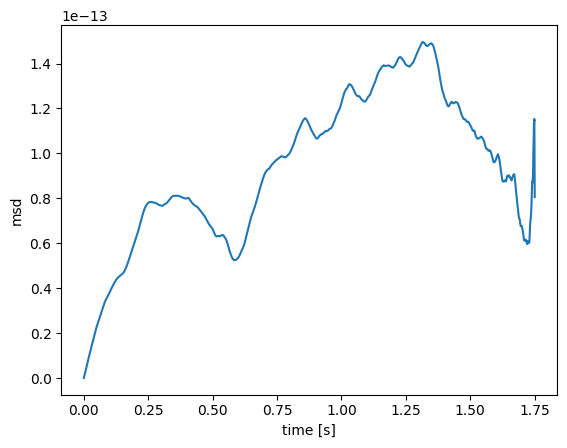

In [20]:
N = 30000
traj_free = walk_free_diffusion(N)
msd_free = mean_square_displacement(traj_free)
t = np.arange(len(msd_free))*dt_s
plt.plot(t,msd_free)
plt.xlabel('time [s]')
plt.ylabel('msd')
plt.show()

Generating W trajectories and computing the respective msd in ordrer to have a mean msd array

In [21]:
def msd_W_trajs(W,N):
    msd_list = []
    mean_msd = np.zeros(N-1)
    for j in range(W):
        traj = walk_free_diffusion(N)
        msd_list.append(mean_square_displacement(traj))
    for msd in msd_list:
        mean_msd = np.add(mean_msd,msd)
    mean_msd *= 1/W
    return mean_msd

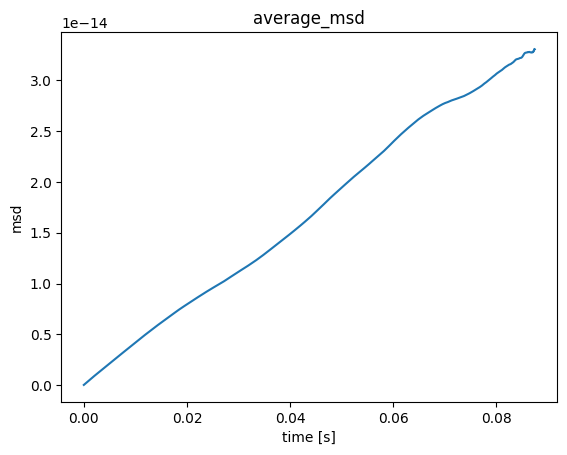

In [22]:
mean_msd = msd_W_trajs(100,1500)
t = np.arange(len(mean_msd))*dt_s
plt.plot(t,mean_msd)
plt.xlabel('time [s]')
plt.ylabel('msd')
plt.title('average_msd')
plt.show()

R-squared: 0.9953028654714301
Error Range (95% CI): 1.8826420319497731e-13 to 1.8915112573781e-13
diffusion_coefficient 1.8870766446639365e-13 einstein_diffusion 2.197365082360985e-13


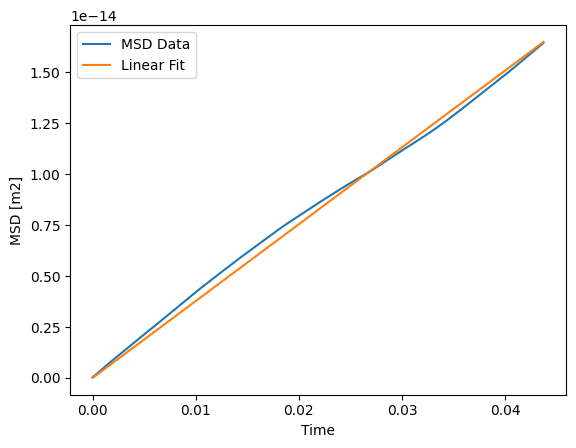

In [23]:
# Fiting the msd

def linear_fit(t, D):
    return 2 * D * t

# Reducing the array for a better fit
mean_msd = mean_msd[0:-int(len(mean_msd)/2)]
t = t[0:-int(len(t)/2)]

initial_guess = 1.0

# Perform the fit
params, covariance = curve_fit(linear_fit, t, mean_msd, p0=initial_guess)

# Extract the diffusion coefficient
diffusion_coefficient = params[0]

#Confidence interval:
residuals = mean_msd - linear_fit(t, diffusion_coefficient)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((mean_msd - np.mean(mean_msd))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R-squared:", r_squared)

std_errors = np.sqrt(np.diag(covariance))
confidence_interval = 1.96 * std_errors  # for 95% confidence interval

print("Error Range (95% CI):", diffusion_coefficient - confidence_interval[0], "to", diffusion_coefficient + confidence_interval[0])
print("diffusion_coefficient",diffusion_coefficient,"einstein_diffusion",einstein_diffusion)
plt.plot(t, mean_msd, label='MSD Data')
plt.plot(t, linear_fit(t , diffusion_coefficient), label='Linear Fit')
plt.xlabel('Time')
plt.ylabel('MSD [m2]')
plt.legend()
plt.show()

Determination of diffusion coefficient in periodic potential

In [24]:
# Additionnal physical parameters:
space_step = 1e-12
amplitude_J = 10*k_b*T_K
frequency_hz = 10e8

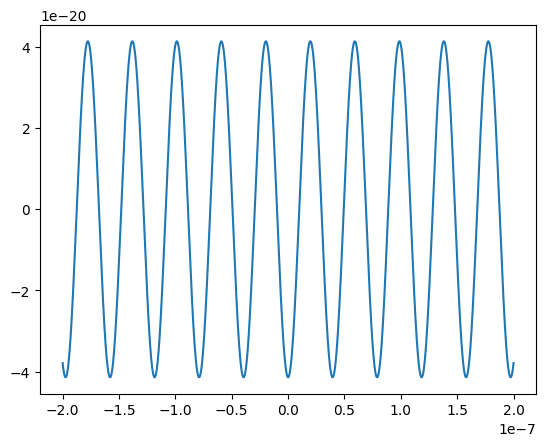

In [25]:
def periodic_potential(A,x):
    return -A*np.cos(x*frequency_hz/(2*np.pi))
X = np.linspace(-200*1e-9,200*1e-9,4000)
plt.plot(X,periodic_potential(amplitude_J,X))
plt.show()

In [26]:
def static_process(N,A):
    x = 0
    stored_position = []
    w = generate_seq(N)
    for i in np.arange(0,N):
        dx = -(1/load)*dt_s*(periodic_potential(A,x+space_step) - periodic_potential(A,x))/space_step
        dx = dx + np.sqrt(2*einstein_diffusion*dt_s)*w[i]
        x = x + dx
        stored_position.append(x)
        dx = 0
    return stored_position

In [27]:
def msd_U_trajs(W,N):
    msd_list = []
    mean_msd = np.zeros(N-1)
    for j in range(W):
        traj = static_process(N,amplitude_J)
        msd_list.append(mean_square_displacement(traj))
    for msd in msd_list:
        mean_msd = np.add(mean_msd,msd)
    mean_msd *= 1/W
    median_position= traj[int(len(traj)/2)]
    return mean_msd,median_position

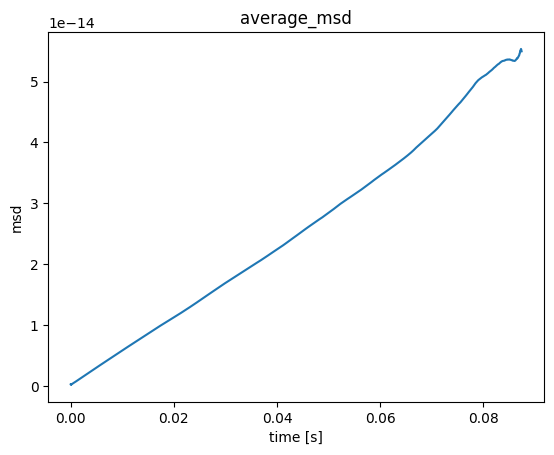

In [28]:
mean_msd,median_position = msd_U_trajs(100,1500)
t = np.arange(len(mean_msd))*dt_s
plt.plot(t,mean_msd)
plt.xlabel('time [s]')
plt.ylabel('msd')
plt.title('average_msd')
plt.show()

R-squared: 0.9996950873632955
Error Range (95% CI): 2.8136950293505876e-13 to 2.817171793278066e-13
periodic_diffusion_coefficient 2.815433411314327e-13 einstein_diffusion 2.197365082360985e-13


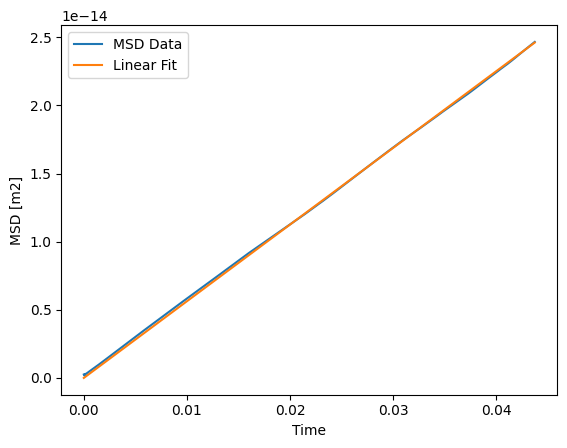

In [29]:
def linear_fit(t, D):
    return 2 * D * t

initial_guess = 1.0
# Reducing the array for a better fit
mean_msd = mean_msd[0:-int(len(mean_msd)/2)]
t = t[0:-int(len(t)/2)]
# Perform the fit
params, covariance = curve_fit(linear_fit, t, mean_msd, p0=initial_guess)

# Extract the diffusion coefficient
diffusion_coefficient = params[0]

#Confidence interval:
residuals = mean_msd - linear_fit(t, diffusion_coefficient)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((mean_msd - np.mean(mean_msd))**2)
r_squared = 1 - (ss_res / ss_tot)
print("R-squared:", r_squared)

std_errors = np.sqrt(np.diag(covariance))
confidence_interval = 1.96 * std_errors  # for 95% confidence interval

print("Error Range (95% CI):", diffusion_coefficient - confidence_interval[0], "to", diffusion_coefficient + confidence_interval[0])
print("periodic_diffusion_coefficient",diffusion_coefficient,"einstein_diffusion",einstein_diffusion)
plt.plot(t, mean_msd, label='MSD Data')
plt.plot(t, linear_fit(t , diffusion_coefficient), label='Linear Fit')
plt.xlabel('Time')
plt.ylabel('MSD [m2]')
plt.legend()
plt.show()

In [30]:
import scipy.integrate as integrate
median_position = np.sqrt(median_position*median_position)

# Computing the integrals
def fmin(x):
    return np.exp(-periodic_potential(amplitude_J,x)/(k_b*T_K))
X = np.linspace(0,median_position,10000)
I0min, _ =  integrate.quad(fmin, 0, median_position)
I0min = (1/frequency_hz)*I0min

def fplus(x):
    return np.exp(periodic_potential(amplitude_J,x)/(k_b*T_K))

# Use a loop to calculate the integral for each value of x
expectation_fplus_values = np.zeros_like(X)
for i, x_val in enumerate(X):
    J, _ = integrate.quad(fplus, 0, x_val)
    expectation_fplus_values[i] = (1 / frequency_hz) * J

# Calculate the derivative using numpy.gradient
df_dx = np.gradient(expectation_fplus_values, X)

print(df_dx[:-1])


corrected_D = (I0min*df_dx[:-1])*diffusion_coefficient
print("corrected_diffusion_coefficient",corrected_D,"einstein_diffusion",einstein_diffusion)
print(median_position,np.cos(median_position))

[4.54000629e-14 4.54004622e-14 4.54016602e-14 ... 4.50804324e-13
 4.54653676e-13 4.58537722e-13]
corrected_diffusion_coefficient [3.52826370e-39 3.52829474e-39 3.52838784e-39 ... 3.50342364e-38
 3.53333886e-38 3.56352370e-38] einstein_diffusion 2.197365082360985e-13
8.332586288773376e-08 0.9999999999999966
